In [1]:
%matplotlib inline
# tells matplotlib to display plots in notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!rm -f data
!ln -s '/content/drive/My Drive/data' data

data = np.load('/content/drive/My Drive/data.npz') # loads the data from data.npz
mydata = data.get('data') # 'data' is the key used to extract the data into a workable form from the NpzFile object
print(mydata.shape) # confirm it is loaded in 1001x2048 shape

Mounted at /content/drive
(1001, 2048)


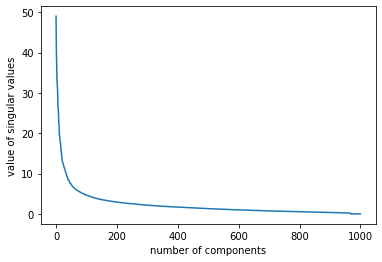

In [3]:
pca = PCA().fit(mydata)
plt.plot(pca.singular_values_)
plt.xlabel('number of components')
plt.ylabel('value of singular values');

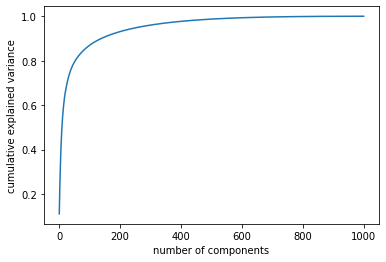

In [4]:
pca = PCA().fit(mydata)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [5]:
pca_X = PCA(0.9) # PCA(k) means we choose the smallest value of d that preserves k*100% of the variance.
pca_X.fit(mydata)
mydata_pca = pca_X.transform(mydata)
print("original shape: ", mydata.shape)
print("transformed shape:", mydata_pca.shape)
# np.cumsum(pca_X.explained_variance_ratio_) returns a nparray containing the cumulative sums of the variances. We print its size to see the value of d we use.
D = np.cumsum(pca_X.explained_variance_ratio_).size
N = mydata.shape[0] # number of data points = 1001
print("Value of d used: ", D)

original shape:  (1001, 2048)
transformed shape: (1001, 139)
Value of d used:  139


## Task 2

In [6]:
from sklearn.metrics import pairwise_distances

def kmeans(dataset, metric, k):
  # dataset: N d-dimensional vectors
  # metric: callable object which returns distance of two points
  # k: number of clusters we want, defined by k d-dimensional vectors, with k_i (i in [1, k]) being the center vector of cluster i.

  # random initialisation of cluster centers (k by d matrix) by permuting dataset
  # note that np.random.permutation makes a copy of the array then permutes it, whereas shuffle does it in place
  # if you want, you can fix a certain seed
  #seed = 831
  #np.random.seed(seed)
  prev_centers = np.random.permutation(dataset)[:k,:]
  #np.random.seed(seed)
  centers = np.random.permutation(dataset)[:k,:]

  # an Nx1 vector whose value j is the cluster C_j that the vector at that index belongs to
  clusters = []

  epsilon = 0.01 # for convergence criterion

  max_iter = 100
  for i in range(max_iter):
    # pairwise_distances takes in two vector arrays X and Y, and returns a distance matrix dist where dist(i,j)=distance from X[i] to Y[j]
    # in our case, it should have shape N*k
    dist = pairwise_distances(dataset, centers, metric=metric)
    
    # in dist, each element from 1 to N is a vector of size k. The smallest element (smallest distance) of that vector is the cluster that element should belong to.
    # np.min(dist, axis=1) finds the row-wise minimum of matrix 'dist' of size N*k, thereby returning a vector of size N*1. If we wanted to find column wise minimum, use 'axis=0'
    # argmin finds the index corresponding to minimum value of each row (when axis=1), for every row. Turns N*k into N*1
    clusters = np.argmin(dist, axis=1)

    # update cluster centers to be mean of all vectors in current cluster. Turns N*D vectors in the dataset into k*D total (1*D in each iteration)
    prev_centers = centers
    for j in range(k):
      ind = np.where(clusters==j)[0]
      cluster_vectors = np.take(dataset, indices=ind, axis=0)
      centers[j] = np.mean(cluster_vectors,axis=0)
    
    # convergence criterion. If distance from current cluster centers to centers of previous iteration do not exceed some criterion, exit loop and return current clusters
    # returns a k*k matrix with 0s along diagonals. Our convergence criterion: If the max norm of this matrix (largest element) does not exceed epsilon, break
    if np.linalg.norm(pairwise_distances(prev_centers,centers,metric=metric), np.inf) <= epsilon:
      print("Convergence reached!")
      break
  
  return clusters


## Task 3


In [7]:
# only used to check answers in Task 4
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

def db(dataset, labels):
  # how to get k? we assume each point covers all k clusters.
  k=max(labels)+1
  centers=np.zeros(shape=(k,D))

  sck = [] # S(C_k) values for all k

  # get the centers
  for j in range(k):
    ind = np.where(labels==j)[0]
    cluster_vectors = np.take(dataset, indices=ind, axis=0)
    centers[j] = np.mean(cluster_vectors,axis=0)
    # compute pairwise euclidean distance, returns a |C_j|*1 matrix
    dist = np.average(pairwise_distances(cluster_vectors, [centers[j]], metric='euclidean'))
    
    # take the average of all elements
    sck.append(dist)
  
  # returns a k*k matrix. In each row, need to find the maxima.
  cluster_dist = pairwise_distances(centers, centers, metric='euclidean')
  
  retval = 0
  for j in range(k):
    retval += max((sck[j]+sck[l])/cluster_dist[l,j] for l in range(k) if l!=j)
  return retval/k

def sil(dataset, labels):
  k=max(labels)+1
  
  # let clusters be an array of size k*N*D.
  # The jth element of clusters is an N*D matrix where the first |C_j| elements are nonzero and contain the D-dimensional vectors of cluster j
  clusters = np.zeros(shape=(k,N,D))

  end_indices = [] # array of size k that stores the number of elements in each cluster
  for j in range(k):
    ind = np.where(labels==j)[0]
    end_indices.append(ind.size)
    cluster_vectors = np.take(dataset, indices=ind, axis=0)
    clusters[j,:cluster_vectors.shape[0],:] = cluster_vectors
  
  # calculate b(x_i, C_k) for all x_i (N total entries)
  b = np.zeros(shape=(k,N))
  for j in range(k):
    candidates = np.zeros(shape=(k-1,end_indices[j])) # there are k-1 "OTHER" clusters, hence k-1 potential minimizers
    offset=0
    for l in range(k):
      if l==j:  # don't compute this case
        offset+=1
        continue
      # produces a |C_j| * |C_l| matrix storing all pairwise distances between vectors in cluster l and cluster j
      betweenclusters = pairwise_distances(clusters[j,:end_indices[j],:], clusters[l,:end_indices[l],:], metric='euclidean')
      
      # for all x_i in C_j, sum the distances from that x_i to all vectors in cluster l and divide by number of vectors in C_l
      # produces a |C_j|*1 matrix
      candidate_b = np.average(betweenclusters,axis=1)
      candidates[l-offset]=candidate_b
    # now we have k-1 different values. One of them will be the value that minimizes b(x_i, C_k).
    # (We ignored the case where l==j)
    b[j,:end_indices[j]] = np.amin(candidates, axis=0)

  # calculate a(x_i, C_k) for all x_i (N total entries)
  a = np.zeros(shape=(k,N))
  for j in range(k):
    withinclusters = pairwise_distances(clusters[j,:end_indices[j],:], metric='euclidean')
    a_j = np.average(withinclusters, axis=0)
    if withinclusters.shape[0]==1: # catch division by zero
      a_j = 0
    else:
      a_j *= withinclusters.shape[0]/(withinclusters.shape[0]-1) # denominator should be |C_j|-1 not |C_j|
    # I tried using np.sum(withinclusters, axis=0)/(withinclusters.shape[0]-1) but found it to be slightly less numerically stable (some error)
    a[j,:end_indices[j]] = a_j
  
  # calculate max{a, b} for all x_i (N total entries)
  max_ab = np.zeros(shape=(k,N))
  for j in range(k):
    npmax = np.maximum(a[j,:end_indices[j]], b[j,:end_indices[j]]) # get elementwise maximum
    max_ab[j,:end_indices[j]]=npmax

  retval = 0
  for j in range(k):
    retval += np.sum((b[j,:end_indices[j]]-a[j,:end_indices[j]])/max_ab[j,:end_indices[j]])
  return retval/N


## Task 4

In [8]:
# call kmeans with k=3, returns a Nx1 array of which cluster each element belongs to (with our implementation)
kmeans_clusters = kmeans(mydata_pca, 'euclidean', 3)

# calculate DB index and silhouette score for my kmeans implementation
print("====== My Kmeans ======")
print("My DB and Sil implementation:")
print(db(mydata_pca, kmeans_clusters))
print(sil(mydata_pca, kmeans_clusters))

print("Standard expected implementation:")
print(davies_bouldin_score(mydata_pca, kmeans_clusters))
print(silhouette_score(mydata_pca, kmeans_clusters))


# k*D matrix where element i is the D-dimensional vector corresponding to center of cluster C_i
# our implementation
kmeans_sol = np.zeros(shape=(max(kmeans_clusters)+1,D))

for j in range(max(kmeans_clusters)+1):
  ind = np.where(kmeans_clusters==j)[0]
  cluster_vectors = np.take(mydata_pca, indices=ind, axis=0)
  kmeans_sol[j] = np.average(cluster_vectors,axis=0)

====== My Kmeans ======
My DB and Sil implementation:
3.209696127693603
0.06253241413749511
Standard expected implementation:
3.209696127693603
0.0625324141374951


## Task 4
Here we plot our KMeans result via TSNE by transforming our D-dimensional data into 2-dimensional data, as well as the corresponding cluster centers.

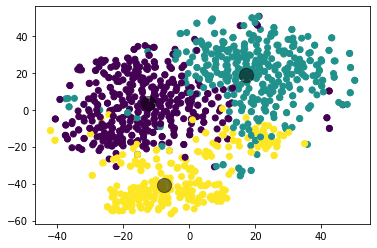

In [9]:
# plot our kmeans implementation result with TSNE transform
from sklearn.manifold import TSNE

myRandomState=1001
tsne = TSNE(n_components=2, random_state=myRandomState)

# According to https://stackoverflow.com/questions/49213930/centroids-are-not-centered-at-clusters, applying tSNE on center vectors and data separately is applying them on two different manifolds (embedding onto two different spaces)
# So we concatenate the dataset with the k D-dimensional vectors that denote the centers of the k clusters
tsne_points = tsne.fit_transform(np.concatenate((mydata_pca, kmeans_sol), axis=0))

# plot the first N points according to their respective cluster colour
plt.scatter(tsne_points[:N,0], tsne_points[:N,1], c=kmeans_clusters, cmap='viridis')
# plot the last k points in black - they are the cluster centers
plt.scatter(tsne_points[N:,0], tsne_points[N:,1], c='black', s=200, alpha=0.5)

## Task 5

Here we derive a distance metric to use based off the similarity measure.

In [34]:
import sys
# just to be safe, I downloaded all of the Mac, Windows and Linux binaries and put everything in the same directory as this .ipynb
sys.path.append('/content/drive/My Drive/Colab Notebooks/Assignment 2/')
from comp4211 import sim

# try the Gaussian/RBF kernel since that one is parameterised by sigma and maps to [0, 1]
# the standard Gaussian kernel takes the form K(x,y)=e^((-||x-y||^2)/(2*sigma^2))
# I fiddled with some options and made it so that the parameter that is passed to the blackbox = 1/(2*sigma^2) as defined in standard Gaussian kernel
# that seems to match the black box implementation - with some small numerical error (order of 10^-16)
testsim = lambda x, y, sigma: np.exp(-(np.linalg.norm(x-y,ord=2)**2)*(sigma))

#sigma=0.6
#myvec1=np.random.rand(20)
#myvec2=np.random.rand(20)
#print(abs(sim(myvec1, myvec2, sigma)-testsim(myvec1, myvec2, sigma)))

From the task description, our chosen distance metric $D$ must satisfy the following:

If $sim(x,y,$$\sigma$$)=x^Ty$ (the inner product) then $D(x,y)=||x-y||_2$ (euclidean distance.) We prove that our chosen $D$ satisfies this.

If $sim(x,y,\sigma)=x^Ty$ then $sim(x,x,\sigma)=x^Tx$. And since $sim(x,x,\sigma)=1$ by definition, we may rewrite our metric as follows:

$D(x,y)=\sqrt{2-2sim(x,y,\sigma)}$

$D(x,y)=\sqrt{x^Tx+y^Ty-2sim(x,y,\sigma)}$

$D(x,y)=\sqrt{x^Tx+y^Ty-2x^Ty}$

$D(x,y)=\sqrt{(x-y)^T(x-y)}$

$D(x,y)=\sqrt{||x-y||_2^2}=||x-y||_2$






## Task 6
Here we use kmeans with the distance metric defined in Task 5.



====== My Kmeans ======
My DB and Sil implementation:
2.8936117934986143
0.08924548090289151


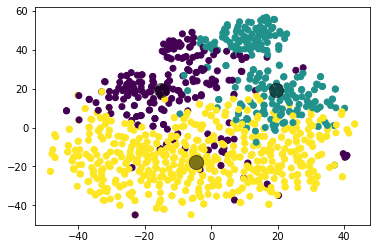

In [45]:
# returns a function that can be used as a metric for calculating distances, with sigma=0.0005
# I have also tried sigma=999.9, but although that one makes the clustering solution (DB: 0.99, Sil: roughly -0.08),
# 2 of the 3 clusters produced only consist of one vector, and the 3rd cluster consists of all the other vectors.
induced_distance = lambda x, y: (2-2*sim(x,y,0.0005))**0.5

# call kmeans with k=3, returns a Nx1 array of which cluster each element belongs to (with our implementation)
kmeans_clusters_induced = kmeans(mydata_pca, induced_distance, 3)

# calculate DB index and silhouette score for my kmeans implementation
print("====== My Kmeans ======")
print("My DB and Sil implementation:")
print(db(mydata_pca, kmeans_clusters_induced))
print(sil(mydata_pca, kmeans_clusters_induced))

tsne_induced = TSNE(n_components=2, random_state=myRandomState)

# k*D matrix where element i is the D-dimensional vector corresponding to center of cluster C_i
kmeans_sol_induced = np.zeros(shape=(max(kmeans_clusters_induced)+1,D))

for j in range(max(kmeans_clusters_induced)+1):
  ind = np.where(kmeans_clusters_induced==j)[0]
  cluster_vectors = np.take(mydata_pca, indices=ind, axis=0)
  kmeans_sol_induced[j] = np.average(cluster_vectors,axis=0)

# According to https://stackoverflow.com/questions/49213930/centroids-are-not-centered-at-clusters, applying tSNE on center vectors and data separately is applying them on two different manifolds (embedding onto two different spaces)
# So we concatenate the dataset with the k D-dimensional vectors that denote the centers of the k clusters
tsne_induced_points = tsne.fit_transform(np.concatenate((mydata_pca, kmeans_sol_induced), axis=0))

# plot the first N points according to their respective cluster colour
plt.scatter(tsne_induced_points[:N,0], tsne_induced_points[:N,1], c=kmeans_clusters_induced, cmap='viridis')
# plot the last k points in black - they are the cluster centers
plt.scatter(tsne_induced_points[N:,0], tsne_induced_points[N:,1], c='black', s=200, alpha=0.5)